<h1><center>PHYS-F-303</center></h1>
<h1><center>Partie numérique</center></h1>
<h2><center>Cédric SCHOONEN, Maxime JAMOTTE</center></h2>

# Table des matières

Leçon 06_02
- <a href="#Question21"> Question 1</a><br />
- <a href="#Question22"> Question 2</a><br />

Leçon 06_03
- <a href="#Question31"> Question 1</a><br />
- <a href="#Question32"> Question 2</a><br />

Leçon 06_04
- <a href="#Question41"> Question 1</a><br />
- <a href="#DomainedeWeiss"> Domaine de Weiss</a><br />
- <a href="#Question42"> Question 2</a><br />

Conclusion

In [2]:
import time
from matplotlib import pyplot as plt
import numpy as np
import random
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

# Leçon 06_02

<h2 id="Question21">Question 1</h2>

Le langage Python possède des fonctions précompilées pour générer des nombres distribués de différentes manières, notamment selon une gaussienne ou selon une exponentielle. 

### Distribution exponentielle

Nous écrivons notre distribution exponentielle comme $$ f(x,\lambda) = f(x,1/\beta) = \dfrac{1}{\beta} e^{-x/\beta} $$

In [67]:
# numpy.random.exponential

""" Parameters:
    ----------
    lambd : float or array_like of floats

        The scale parameter is \beta = 1/\lambda.

    size : int or tuple of ints, optional

        Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. If size is None
        (default), a single value is returned if scale is a scalar. Otherwise, np.array(scale).size samples are
        drawn.

    Returns:
    -------
    out : ndarray or scalar

        Drawn samples from the parameterized exponential distribution."""

lambd = 4
size = 100000
rand_exponential = np.random.exponential(lambd,size)

/home/maxime/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


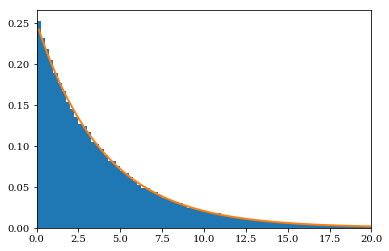

In [68]:
# Plots
xmax = 20

binwidth=0.25
plt.xlim(0,xmax)
bins=np.arange(0.,xmax+1, binwidth)
plt.hist(rand_exponential,bins,normed=True);

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,1/lambd*np.exp(-xc/lambd), lw=2);

Nous retrouvons un résultat identique à celui présenté dans la leçon 06_02. La courbe jaune suit bien l'allure de l'histogramme.

### Distribution gaussienne

La fonction $standard\_normal$est une fonction nous donnant une liste de nombre distribués selon une loi normale.

In [75]:
# numpy.random.standard_normal

""" Parameters:
    ----------
    size : int or tuple of ints, optional

        Output shape. If the given shape is, e.g., (m, n, k), then m * n * k samples are drawn. If size is 
        None (default), a single value is returned if loc and scale are both scalars. 
        Otherwise, np.broadcast(loc, scale).size samples are drawn.

    Returns:
    -------
    out : ndarray or scalar

        Drawn samples from the parameterized normal distribution."""

size = 100000
distrNormal = np.random.standard_normal(size)

/home/maxime/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


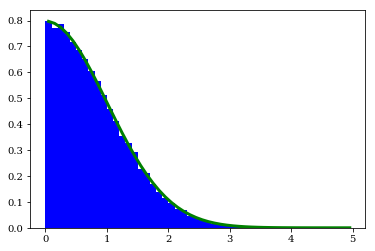

In [76]:
# Plots
binwidth=0.1
bins=np.arange(0.,5.1, binwidth)
plt.hist(distrNormal,bins=np.arange(0.,5., binwidth),normed=True,color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,2*np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=3,color='green');

A nouveau, nous constatons que la loi normale (en vert) épouse bien le profil de l'histogramme.

Ci-dessous, nous présentons une autre façon de générer des nombres suivant une distribution gaussienne pouvant avoir une moyenne différente de 0 et un écart-type différente de 1.

In [35]:
mu = 2
sigma = 0.5
x = np.empty(100000)

for i in range(len(x)):
    x[i] = random.gauss(mu,sigma)

/home/maxime/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


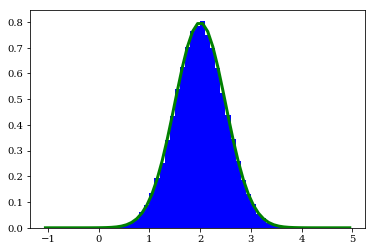

In [36]:
# Plots
binwidth=0.1
bins=np.arange(-1.1,5.1, binwidth)
plt.hist(x,bins=np.arange(0.,5., binwidth),normed=True,color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-(xc-mu)**2/2.0/sigma**2)/np.sqrt(2*np.pi)/sigma,lw=3,color='green');

<h2 id="Question22">Question 2</h2>

Nous codons ici la méthode dite de "Box-Muller".

In [7]:
N = 10000

u1 = np.random.random_sample(N)
u2 = np.random.random_sample(N)

In [8]:
z0 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
z1 = np.sqrt(-2*np.log(u2))*np.sin(2*np.pi*u1)

/home/maxime/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


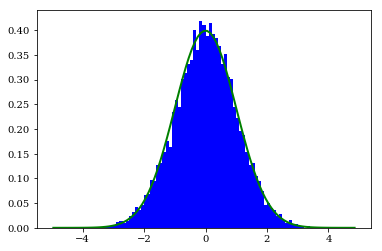

In [9]:
# Plots
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z0,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green')

/home/maxime/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


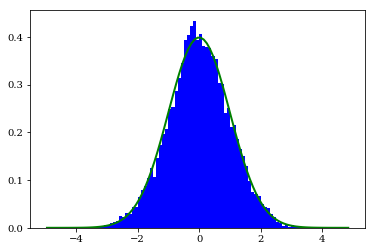

In [10]:
# Plots
binwidth=0.1
bins=np.arange(-5,5, binwidth)
plt.hist(z1,bins,normed='true',color='blue');

# Compute centers of bins
xc = bins[:-1] + binwidth/2
plt.plot(xc,np.exp(-xc**2/2.0)/np.sqrt(2*np.pi),lw=2,color='green')

# Leçon 06_03

## <h2 id="Question 31">Question 1</h2>

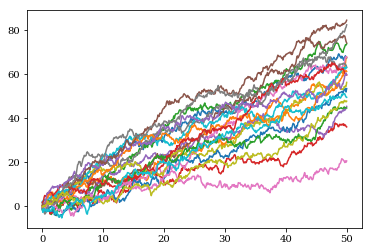

In [11]:
npart=10000
T=50.0
nt=500
dt=T/nt
alpha=2
c = 1

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt+1,npart])

x[0]=x0

for i in range(nt):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)+c*dt

for i in range(20):
    plt.plot(t,x[:,i])

On remarque une translation générale des particules vers les $x$ positifs si $c$ est positif et vers les $x$ négatifs si $c$ est négatif. 

## Question 2

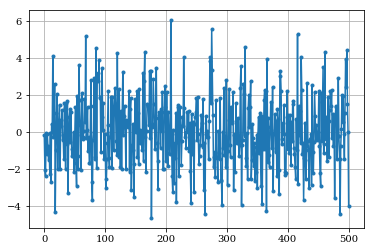

In [12]:
npart=2000
npart2plot = 1

T = 500.0
dt = 1
nt = int(T/dt)+1
alpha = 2
gamma = 1

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt,npart])

x[0]=x0

for i in range(nt-1):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)-gamma*x[i]*dt

for i in range(npart2plot):
    plt.plot(t,x[:,i],'.-')
plt.grid()

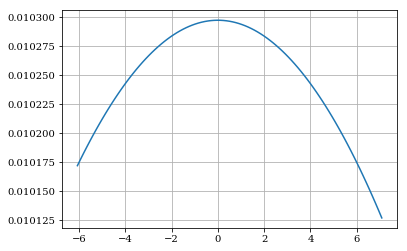

In [13]:
# Generate bins centered around 0
xmin = np.min(x[nt-1])
xmax = np.max(x[nt-1])

binwidth = (xmax-xmin)/100

bins=np.arange(xmin,xmax,binwidth)
bins = bins + binwidth/2

# Compute bin centers
bin_centers = bins[:-1]+binwidth/2

# plot a histrogram for verification
#plt.hist(x[nt-1],bins,normed=True);

sigmat2=2*alpha*T+sigma**2-gamma*T
plt.plot(bin_centers,np.exp(-bin_centers**2/(2.0*sigmat2))/np.sqrt(2*np.pi*sigmat2))
plt.grid()

In [14]:
sigmat2

1501.0

A cause du terme de friction, on remarque une atténuation de l'écart par rapport à la position centrale pour des $\gamma <2$. Faire varier l'écart-type pour contracrrer l'effet d'un $\gamma$ trop grand?

### Remarques

Cet algorithme est instable! Nous remarquons que pour des $\gamma$ au-delà de 2, il y a comme une divergence.

In [15]:
npart=1

T = 10000.0
dt = 1
nt = int(T/dt)+1
alpha=2
gamma = 2.4

sigma = 1.0
x0 = np.random.normal(loc=0,scale=sigma,size=npart)

t = np.arange(0,T+dt,dt)
x = np.empty([nt,npart])

x[0]=x0

for i in range(nt-1):
    x[i+1]=x[i]+np.sqrt(2*alpha*dt)*np.random.normal(0,1,npart)-gamma*x[i]*dt

for i in range(1):
    plt.plot(t[2070:2200],x[2070:2200,i],'.-')
plt.grid()

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd44cead598> (for post_execute):


/home/maxime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/home/maxime/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/home/maxime/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1910: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale
/home/maxime/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1720: RuntimeWarning: overflow encountered in double_scalars
  return (d + 1) * self._base


ValueError: Maximum allowed size exceeded

ValueError: Maximum allowed size exceeded

<Figure size 432x288 with 1 Axes>

# Leçon  06_04: Modèle d'Ising

## Challenge (vers le milieu du MOOC)

## Question 1: Calculer la magnétisation moyenne pour différentes valeurs de $\alpha$ entre 0 et 1 et estimer la valeur de $\alpha$ critique

Nous calculons la magnétisation moyenne comme: $$ \left \langle M \right \rangle = \dfrac{\sum_{k=1}^{N} M_k }{N} $$ avec $M_k = \sum_{i=1}^{b} s_i$ où $N$ est le nombre de tranches simulées et $b$ le nombre de cases dans une tranche dans lesquelles se trouvent les spins que nous sommons.

Commençons par définir les fonctions à utiliser pour observer l'évolution de la magnétisation pour un alpha donné.

In [145]:
def initial_state_random(nx,ny):
    """ Creates a lattice with random spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
       
    # Uniform random spins between 0 and 1  
    r = np.random.randint(0,2,(nx,ny))
    
    # Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

In [146]:
def initial_state_aligned(nx,ny):
    """ Creates a lattice with aligned spin orientations
   
    Parameters:
    ----------
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
   
    Returns:
    -------
    r: 2D array of spins
    """
    
    r = np.ones([nx,ny])
    
    return r

In [147]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]\
                         +sp[ix,(iy+1)%ny])

    return energy

In [148]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]

In [149]:
def moy_magn(sp): 
    """ Computes the average magnetisation for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    M: average magnetisation for the lattice state sp 
    """
    
    M = sp.sum(axis=(0,1))/(len(sp)*len(sp[0]))
    return M

In [150]:
def moy_ener(sp,alpha): 
    """ Computes the average energy for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    E: average energy for the lattice state sp 
    """
    pairsNorth = np.multiply(sp,np.roll(sp,-1,axis=0)) # pas de boucle -> + efficace à priori
    pairsEast  = np.multiply(sp,np.roll(sp,-1,axis=1))
    pairsSouth = np.multiply(sp,np.roll(sp,1,axis=0))
    pairsWest  = np.multiply(sp,np.roll(sp,1,axis=1))
    E = -alpha * (pairsNorth.sum(axis=(0,1)) + pairsEast.sum(axis=(0,1)) 
                      + pairsSouth.sum(axis=(0,1)) + pairsWest.sum(axis=(0,1)))
    E = E/(len(sp)*len(sp[0]))
           
    return E

In [171]:
def moy_ener_vect(sp,alphas): 
    """ Computes the average energy for a given state
   
    Parameters:
    ----------
    sp   : lattice state
    
    Returns:
    -------
    E: average energies for the lattice state sp for all the alpha's values
    """
    E = np.empty(len(alphas))
    for i in range(len(alphas)):
        pairsNorth = np.multiply(sp,np.roll(sp,-1,axis=0)) # pas de boucle -> + efficace à priori
        pairsEast  = np.multiply(sp,np.roll(sp,-1,axis=1))
        pairsSouth = np.multiply(sp,np.roll(sp,1,axis=0))
        pairsWest  = np.multiply(sp,np.roll(sp,1,axis=1))
        E[i] = -alphas[i] * (pairsNorth.sum(axis=(0,1)) + pairsEast.sum(axis=(0,1)) 
                          + pairsSouth.sum(axis=(0,1)) + pairsWest.sum(axis=(0,1)))
        E[i] = E[i]/(len(sp)*len(sp[0]))
           
    return E

In [172]:
def M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling constant for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    M: magnetisation 
    E: energie 
    """
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
        #if i%(int(NMC/10)+1)==0:
            #print("loop {:d} of {:d} for alpha = {:.2f}".format(i,NMC,alpha))
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp,alpha)
    return [M,E]

Calculons l'évolution de la magnétisation pour un alpha donné afin de vérifier que le code fonctionne bien.

In [23]:
NMC = 300 
step = 1
nx = 20 
ny = 20
alpha = 0.35

sp = initial_state_aligned(nx,ny)
E_aligned = moy_ener(sp,alpha)

[M,E] = M_with_time_for_alpha(sp,nx,ny,NMC,step,alpha)

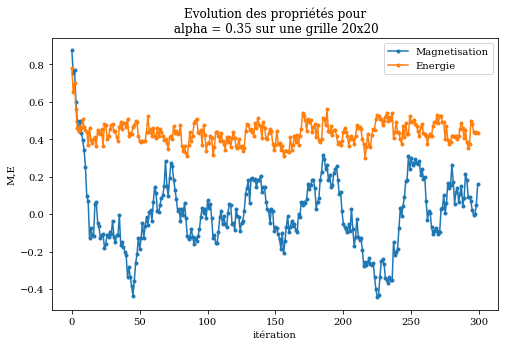

In [24]:
plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),E/E_aligned, '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
plt.legend(loc=1);
plt.show()

Ce graphique nous permet d'estimer le nombre d'itération nécessaire pour atteindre un équilibre statistique. Nous allons en avoir besoin pour calculer les propriétés (magnétisation et énergie) du sysème à l'équilibre. Pour automatiser ce calcul pour plusieurs valeurs de $\alpha$, il nécessaire de s'assurer que le nombre d'itération attendues pour atteindre l'équilbre majore celui nécessaire pour chaque valeur de $\alpha$. C'est pourquoi nous avons testé plusieurs valeurs de alpha et choisi pour ce graphique une valeur de alpha parmi celles qui met le plus de temps à atteindre l'équilibre pour un état initial de spins alignés. Nous avons répété plusieurs fois l'algorithme pour cette valeur et avons observé que l'équilibre était toujours atteint avant 50 itérations, nous prendrons 100 itérations pour être sûr d'avoir atteint l'équilibre. Notons que pour des valeurs de alpha proche de la transition (vers 0.4), les propriétés du système (magnétisation, énergie) fluctuent beaucoup.

Automatisons maintenant la procédure pour calculer la magnétisation à l'équilibre pour un grand nombre de couplages différents.

In [98]:
def M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq):
    """ Computes averages of physical quantities at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    Returns:
    -------
    Ms     : Vector of magnetisations at equilibrium for each alpha in alphas
    Es     : Vector of energis at equilibrium for each alpha in alphas
    VarEs  : Vector of the variances of the energy at equilibrium for each alpha in alphas
    """
    
    Ms  = np.empty([len(alphas)])
    Es  = np.empty([len(alphas)])
    VarEs = np.empty([len(alphas)])
    
    for i in range(len(alphas)):
        
        print("loop at alpha = {:.3f}".format(alphas[i]))
        
        for j in range(NMC_eq):
            
            for j in range(0,nx*ny):
                ix = np.random.randint(0,nx)
                iy = np.random.randint(0,ny)
                metropolis_at_site(sps[i],alphas[i],ix,iy)
        
        [M_evol,E_evol] = M_with_time_for_alpha(sps[i],nx,ny,NMC,step,alphas[i])
        Ms[i]  = M_evol.sum()/len(M_evol)
        Es[i]  = E_evol.sum()/len(E_evol)
        VarEs[i] = (E_evol**2).sum()/len(E_evol) - (E_evol.sum()/len(E_evol))**2
    
    return [Ms,Es,VarEs]

Calculons donc la magnétisation d'équilbre pour plusieurs valeurs de $\alpha$.

In [26]:
NMC = 100+500
NMC_eq = 100
step = 1
nx = 20
ny = 20
a = 101
alphas = np.linspace(0,1,a)

sps = np.empty([a,nx,ny])
for i in range(a):
    sps[i] = initial_state_aligned(nx,ny)
    
E_aligned = moy_ener_vect(np.ones((nx,ny)),alphas)

[Ms,Es,VarEs] = M_equilibrium_for_alphas(sps,nx,ny,NMC,step,alphas,NMC_eq)

loop at alpha = 0.000
loop at alpha = 0.010
loop at alpha = 0.020
loop at alpha = 0.030
loop at alpha = 0.040
loop at alpha = 0.050
loop at alpha = 0.060
loop at alpha = 0.070
loop at alpha = 0.080
loop at alpha = 0.090
loop at alpha = 0.100
loop at alpha = 0.110
loop at alpha = 0.120
loop at alpha = 0.130
loop at alpha = 0.140
loop at alpha = 0.150
loop at alpha = 0.160
loop at alpha = 0.170
loop at alpha = 0.180
loop at alpha = 0.190
loop at alpha = 0.200
loop at alpha = 0.210
loop at alpha = 0.220
loop at alpha = 0.230
loop at alpha = 0.240
loop at alpha = 0.250
loop at alpha = 0.260
loop at alpha = 0.270
loop at alpha = 0.280
loop at alpha = 0.290
loop at alpha = 0.300
loop at alpha = 0.310
loop at alpha = 0.320
loop at alpha = 0.330
loop at alpha = 0.340
loop at alpha = 0.350
loop at alpha = 0.360
loop at alpha = 0.370
loop at alpha = 0.380
loop at alpha = 0.390
loop at alpha = 0.400
loop at alpha = 0.410
loop at alpha = 0.420
loop at alpha = 0.430
loop at alpha = 0.440
loop at al

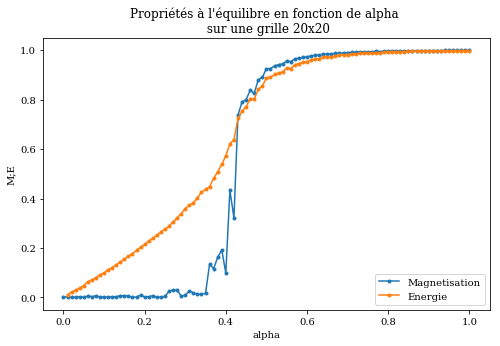

In [27]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

Notons que nous affichons la valeur absolue de la magnétisation, car celle-ci peut converger vers n'importe laquelle des deux orientations. En ce qui concerne l'énergie, nous la divisons par la valeur d'énergie pour un réseau de spins entièrement alignés et prenons ensuite la valeur absolue.

Remarquons que la magnétisation et l'énergie ne se comportent pas de la même façon. Pour de petites valeurs de $\alpha$, la courbe d'énergie se trouve bien au dessus de la magnétisation, cela s'explique par le fait que plus $\alpha$ est grand, plus les spins voisins on tendance à s'aligner et diminuent l'énergie totale, alors que comme se phénomène d'alignement n'a pas lieu à grande échelle, la magnétisation reste petite. En effet, les contributions des différentes zones alignées se compensent et annulent la magnétisation totale. 

Quand nous partons d'une grille de spins désordonnés, nous observons parfois de vaste régions (de taille comparable à celle du système) de spins alignés dans une direction particulière, différente d'une région à l'autre. Ces régions sont l'analogue dans ce modèles des varitables domaines de Weiss que l'on observe dans un matériau ferromagnétique. Ces domaines de Weiss on pour effet de diminuer fortement la magnétisation pour certaines valeurs de $\alpha$ pourtant au dessus de la valeur critique, alors que comme l'énergie est sommée sur les paires voisines, l'orientation différente des domaines ne se ressent qu'à la frontière entre ceux-ci et les diminutions sont donc beaucoup plus petites.

Sur ce graphique des propriétés à l'équibre en fonction du couplage, nous pouvons observer une nette augmention de la magnétisation totale à partir de $\alpha = 0.4$. Cela nous permet de fournir une première estimation de la valeur critique de $\alpha$, que l'on estime à environ $0.4$.

Pour plus de précision sur cette valeur, nous pouvons définir le couplage critique comme la valeur de $\alpha$ où la courbe de magnétisation passe au dessus de $0.5$. Ce point est arbitraire mais vu la valeur très élevée de la pente près du vrai couplage critique, cela devrait constituer une bonne approximation de ce dernier.

In [28]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} $\pm$ {:.2f}".format(alpha_c,err_alpha_c))

Notre couplage critique vaut 0.42 $\pm$ 0.01


Ce résultat est proche de la valeur théorique obtenue par Onsager, qui est:

$$ \alpha = \frac{\ln( 1+\sqrt 2 )}{2} \approx 0.441$$

Gardons évidemment en tête que ce résultat est valable dans la limite où le réseau est de taille infine, le nôtre n'étant consititué que de 20x20 spins.

Cependant, une méthode plus précise existe pour déterminer cette valeur critique. Elle consiste à observer la capacité calorifique en fonction de $\alpha$, le graphique devant présenter un pic à la valeur critique de couplage.

Nous avons relancé une simulation beaucoup plus précise s'étalant sur plusieurs heures de calcul et analysé les résultats dans un **notebook en annexe** ("Compute_Cv_Ising_MJ_CS.ipynb").

Nous avons obtenu comme couplage critique pour une grille de $20\times20$ spins la valeur suivante:

$$ \alpha = 0.4343(2) $$

## Domaine de Weiss

Les domaines de Weiss ne se forment pas à chaque fois que nous faisons tourner le code. Certaines conditions initiales sont plus propices à les créer sans pour autant assurer leur apparition puisque l'évolution dans le temps du sytème est aléatoire, vu la façon dont fonctionne $metropolis\_at\_site$. Il a fallu faire tourner le code quelques fois avant d'observer des domaines de Weiss. 

En annexe de ce document se trouve le fichier $Weiss.mp4$ montrant la formation desdits domaines. Ci-dessous, nous représentons l'évolution de la magnétisation et de l'énergie du système au fur et à mesure des itérations. 

<img src="./Weiss.png" alt="Drawing" style="width: 500px" align="center" />

Le fait que la magnétisation moyenne ait une valeur proche de 0 indique qu'environ la moitié des spins a une direction opposée à la partie restante des spins. La vidéo ci-dessus permet bel et bien de distnguer deux zones - de Weiss - d'orientations distinctes de spins. 

Comme nous l'avons mentionné, il ne nous est pas possible de vous assurer de retomber sur un résultat identique à celui présenté ci-dessus; par rigueur, nous inscrivons tout de même le code qui nous a permis d'obtenir ce que nous venons d'expliquer.

In [153]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = np.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states

In [154]:
NMC = 100
step = 1
nx = 20 
ny = 20
alpha = 0.85

sp_Weiss = initial_state_random(nx,ny)

E_aligned = moy_ener(np.ones((nx,ny)),alpha)
states_Weiss = ising_model_metropolis(sp_Weiss, NMC, nx, ny, alpha)

[M,E] = M_with_time_for_alpha(sp_Weiss,nx,ny,NMC,step,alpha)

In [155]:
fig = plt.figure(figsize=(6,6))
img1 = plt.imshow(states_Weiss[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

# Animate
def animate(i):
    img1.set_array(states_Weiss[i])

anim = animation.FuncAnimation(fig, animate, frames=NMC, interval=200)
plt.close()
HTML(anim.to_html5_video())

In [156]:
# anim.save("Weiss2.mp4") Enlever le " # " créera une vidéo Weiss2.mp4

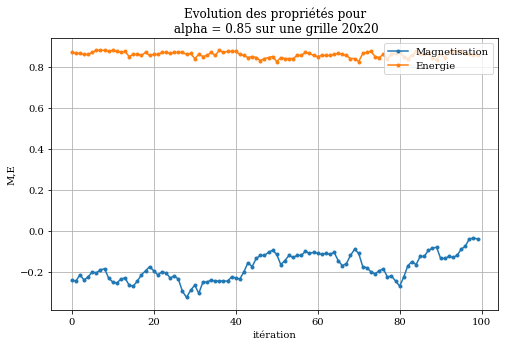

In [157]:
plt.figure(figsize=(8,5));
plt.plot(np.arange(0,len(M)*step,step),M, '.-', label='Magnetisation');
plt.plot(np.arange(0,len(E)*step,step),abs(E/E_aligned), '.-', label='Energie')
plt.title("Evolution des propriétés pour\n alpha = {:.2f} sur une grille {:d}x{:d}".format(alpha,nx,ny));
plt.xlabel('itération');
plt.ylabel('M,E');
plt.legend(loc=1);
plt.grid()
plt.show()

## Question 2

Faisons à présent varier les conditions aux bords et les conditions initiales grâce aux fonctions $edges\_conditions$, $square\_center$ et $init\_chessboard$. Nous modifions en prime quelque peu les fonctions $metropolis\_at\_site$, $M\_with\_time\_for\_alpha$ et $M\_equilibrium\_for\_alphas$ afin d'intégrer dans notre code les conditions aux bords.

In [173]:
def edges_conditions(sp,borders):
    """Fixes the boundary conditions
    
    Parameters:
    ----------
    sp   : array
        Matrix of spins
    borders   : array
        Array of 4 numbers to fix the boundary conditions. The first indice is for the top line, the second one for 
        the left row and so on.
    """
    sp[0,:] = borders[0]*np.ones([1,ny])
    sp[:,[0]] = borders[1]*np.ones([nx,1])
    sp[-1,:] = borders[2]*np.ones([1,ny])
    sp[:,[-1]] = borders[3]*np.ones([nx,1])
    
    return sp

In [174]:
def square_center(sp,a):
    """Fixes the boundary conditions in a square at the center of the frames
    
    Parameters:
    ----------
    sp   : array
        Matrix of spins
    a   : int
        Allows to choose the value of the spins inside the square
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sp[int(nx/4):int(3*nx/4),int(ny/4):int(3*ny/4)] = a*np.ones([int(nx/2),int(ny/2)])
    
    return sp

In [175]:
def init_chessboard(sp):
    """Imposes that one out of two compartments in the initial frame is +1 and the other one -1, as a chessboard
    
    Parameters:
    ----------
    sp   : array
        The matrix "sp" must be initialized before using this function
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sp = np.ones([nx,ny])
    
    for i in range(nx):
        for j in range(ny):
            if (i+j)%2==1:
                sp[i,j] = -1
                
    return sp

In [176]:
def metropolis_at_site2(sp,alpha,ix,iy,param,borders,a):
    """ Flips a dipole at site ix, iy when probability condition is met and refix the boundary conditions
   
    Parameters:
    ----------
    sp   : numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    param   : int
        Allows to choose the boundary conditions to apply
    borders    : Array
        Allows to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allows to choose the value of the spins inside the square 
    """
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (np.random.random_sample()<np.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]
        
    # Fix the boundary conditions
    if param==1:
        sp = edges_conditions(sp,borders)        
    
    elif param==2:
        sp = square_center(sp,a)
    
    elif param==3:
        sp = edges_conditions(sp,borders)
        sp = square_center(sp,a)
        
    return sp

In [177]:
def M_with_time_for_alpha2(sp,NMC,step,alpha,param,borders,a):
    """ Computes the evolution of the magnetisation and energy with time for a given coupling 
    constant for the Ising model using the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alpha  : Double
        coupling constant J/(kb*T)
    param   : int
        Allows to choose the boundary conditions to apply
    borders    : Array
        Allow to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allows to choose the value of the spins inside the square 
        
    Returns:
    -------
    M: magnetisation 
    E: energy
    """
    
    nx = np.shape(sp)[0]
    ny = np.shape(sp)[1]
    
    M = np.empty([int(NMC/step)])
    E = np.empty([int(NMC/step)])
    
    for i in range(int(NMC)):
            
        for j in range(0,nx*ny):
            ix=np.random.randint(0,nx)
            iy=np.random.randint(0,ny)
            metropolis_at_site2(sp,alpha,ix,iy,param,borders,a)
            
        if i%step==0:
            M[int(i/step)] = moy_magn(sp)
            E[int(i/step)] = moy_ener(sp,alpha)
            
    return [M,E]

In [178]:
def M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a):
    """ Computes the average magnetisation and energy at equilibrium with different coupling constants for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sps  : Vector containing the initial lattice states
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    step   : Step between each magnetisation computation
    alphas : Vector of reals containing the
        coupling constants alpha = J/(kb*T)
    NMC_eq : Number of states to create before reaching the equilibrium
    param   : int
        Allows to choose the boundary conditions to apply
    borders    : Array
        Allow to choose the fixed boundary conditions on the frames' egdes
    a   : int
        Allows to choose the value of the spins inside the square
    
    Returns:
    -------
    Ms: Vector of magnetisations at equilibrium for each alpha in alphas
    Es: Vector of energies at equilibrium for each alpha in alphas
    """
    nx = np.shape(sps[0])[0]
    ny = np.shape(sps[0])[1]
    
    Ms = np.empty([len(alphas)])
    Es = np.empty([len(alphas)])
    
    for i in range(len(alphas)):
        
        print("loop at alpha = {:.2f}".format(alphas[i]))
        
        for j in range(NMC_eq):
                
            for j in range(0,nx*ny):
                ix=np.random.randint(0,nx)
                iy=np.random.randint(0,ny)
                metropolis_at_site2(sps[i],alphas[i],ix,iy,param,borders,a)
        
        [M_evol,E_evol] = M_with_time_for_alpha2(sps[i],NMC,step,alphas[i],param,borders,a)
        
        Ms[i] = M_evol.sum()/len(M_evol)
        Es[i] = E_evol.sum()/len(E_evol)
    
    return [Ms,Es]

Nous allons, pour différentes conditions aux bords et initiales, trouver approximativement la valeur de $\alpha$ pou laquelle la transition de phase s'opère. Nous traçons pour ce faire les graphiques de la magnétiation et de l'énergie en fonction de la valeur de $\alpha$ pour chaque cas. Nous repérons ensuite la partie du graphique dont la pente est la plus élevée. 

### Pour des spins valant 1 partout sur les bords extérieurs et des spins initialement orientés aléatoirement 

In [181]:
NMC = 600
NMC_eq = 400
step = 1
nx = 20 # petit pour une simple verification
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 1
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
    sps[i] = initial_state_random(nx,ny)

E_aligned = moy_ener_vect(np.ones((nx,ny)),alphas)

[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


Nous avons affiché les valeurs de $\alpha$ afin de donner une idée du temps mis par le code.

Ci-après, nous donnons les graphiques de la magnétisation et de l'énergie (normailisées) en fonction de la valeur de $\alpha$.

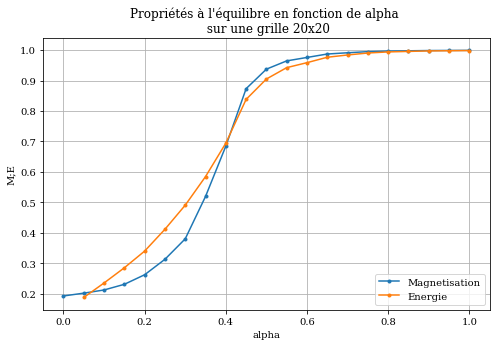

In [182]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

Ensuite, nous affichons une des tranches finales pur une certaine valeur de $\alpha$. Cela nous permet d'avoir une idée de ce qu'il s'est passé au sein du système.

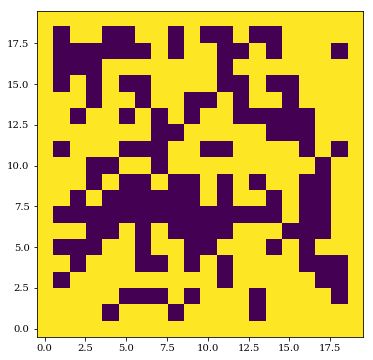

In [183]:
plt.figure(figsize=(6,6))
plt.imshow(sps[3],interpolation="none",origin='lower');

Nous séletionnons enfin a région où il nous semble que la pente du graphique de la magnétisation est la plus forte.

In [184]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} \pm {:.2f}".format(alpha_c,err_alpha_c))

Notre couplage critique vaut 0.33 \pm 0.02


### Pour des spins valant 1 partout sur les bords extérieurs et un échiquier comme condition initiale

In [92]:
NMC = 600
NMC_eq = 400
step = 1
nx = 20 # petit pour une simple verification
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 1
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
     sps[i] = init_chessboard(sps[i])
        
E_aligned = moy_ener(np.ones((nx,ny)),alphas)
    
[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


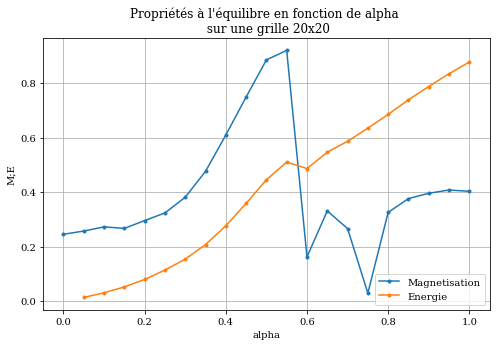

In [126]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

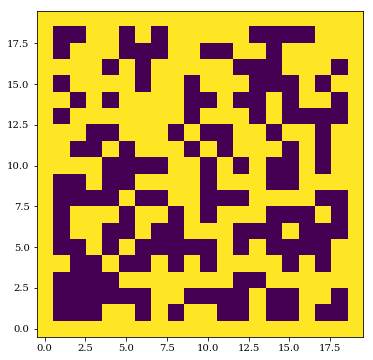

In [94]:
plt.figure(figsize=(6,6))
plt.imshow(sps[0],interpolation="none",origin='lower');

In [95]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} \pm {:.2f}".format(alpha_c,err_alpha_c))

Notre couplage critique vaut 0.33 \pm 0.02


### Remarques

1) Lorsque nous avons fait tourné la partie de code ci-dessus, nous avons obtenu plusieurs fois un graphique ressemblant à celui présent sur la figure suivante:

<img src="./alpha_09.png" alt="Drawing" style="width: 500px" align="center" />

Nous observons une diminution soudaine de la magnétistion, signe de la présence d'un domaine de Weiss. 

2) L'orientation initiale aléatoire donne un résultat très proche de l'orientation initiale en damier, ce à quoi nous pouvions nous attendre puisqu'elles ne diffèrent en général que de quelques spins.

### Pour des spins valant 1 partout sur les bords extérieurs et tous les autres spins mis à -1 initialement

In [185]:
NMC = 600
NMC_eq = 400
step = 1
nx = 20 
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 1
borders = [1,1,1,1]
a = 1


for i in range(len_alpha):
     sps[i] = -1*initial_state_aligned(nx,ny)
        
E_aligned = moy_ener(np.ones((nx,ny)),alphas)
    
[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


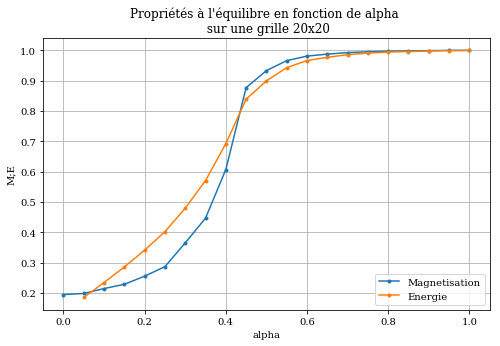

In [186]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

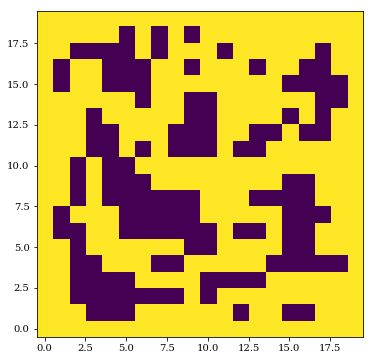

In [187]:
plt.figure(figsize=(6,6))
plt.imshow(sps[5],interpolation="none",origin='lower');

In [188]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dus aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} \pm {:.2f}".format(alpha_c,err_alpha_c))

Notre couplage critique vaut 0.38 \pm 0.02


### Pour les spins du centre de la tranche valant tous 1

In [190]:
NMC = 300
NMC_eq = 200
step = 1
nx = 20 # petit pour une simple verification
ny = 20
len_alpha = 21
alphas = np.linspace(0,1,len_alpha)

sps = np.empty([len_alpha,nx,ny])

param = 2
borders = [1,1,1,1]
a = 1

for i in range(len_alpha):
     sps[i] = -initial_state_aligned(nx,ny)
        
E_aligned = moy_ener(np.ones((nx,ny)),alphas)
    
[Ms,Es] = M_equilibrium_for_alphas2(sps,NMC,step,alphas,NMC_eq,param,borders,a)

loop at alpha = 0.00
loop at alpha = 0.05
loop at alpha = 0.10
loop at alpha = 0.15
loop at alpha = 0.20
loop at alpha = 0.25
loop at alpha = 0.30
loop at alpha = 0.35
loop at alpha = 0.40
loop at alpha = 0.45
loop at alpha = 0.50
loop at alpha = 0.55
loop at alpha = 0.60
loop at alpha = 0.65
loop at alpha = 0.70
loop at alpha = 0.75
loop at alpha = 0.80
loop at alpha = 0.85
loop at alpha = 0.90
loop at alpha = 0.95
loop at alpha = 1.00


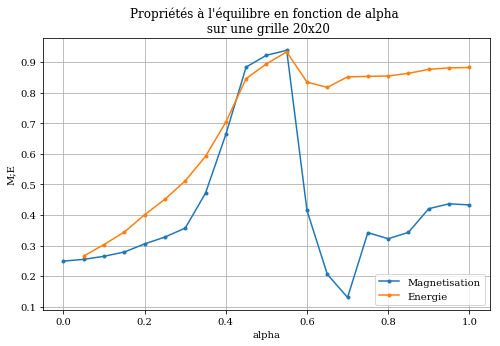

In [192]:
plt.figure(figsize=(8,5));
plt.plot(alphas,abs(Ms), '.-', label='Magnetisation');
plt.plot(alphas[1:],abs(Es[1:]/E_aligned[1:]), '.-', label='Energie');
plt.title("Propriétés à l'équilibre en fonction de alpha \n sur une grille {:d}x{:d}".format(nx,ny));
plt.xlabel('alpha');
plt.ylabel('M;E');
plt.legend(loc=4);
plt.grid()
plt.show()

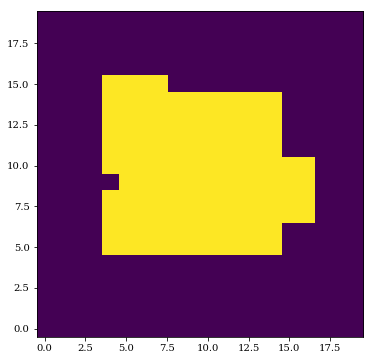

In [118]:
plt.figure(figsize=(6,6))
plt.imshow(sps[39],interpolation="none",origin='lower');

In [ ]:
for i in range(len(alphas)-1):
    if (abs(Ms[i])<=0.5) & (abs(Ms[i+1])>0.5):
        alpha_c = (alphas[i+1]+alphas[i])/2 
        err_alpha_c = (alphas[i+1]-alphas[i])/2
        break # afin de ne pas détecter les pics dû aux domaines de Weiss non alignés

print("Notre couplage critique vaut {:.2f} \pm {:.2f}".format(alpha_c,err_alpha_c))

## Remarques

# Conclusion